# FIFI-LS Resampling Examples

In [1]:
# Initial imports
import glob
import numpy as np
import time
from sofia_redux.toolkit.resampling.resample import *
import matplotlib.pyplot as plt
import tempfile
import warnings

# pyredux needs to be installed
with warnings.catch_warnings():
    warnings.simplefilter("ignore", ImportError)
    from sofia_redux.pipeline.sofia.fifils_reduction import FIFILSReduction
    
# pyfifi needs to be installed
from sofia_redux.instruments.fifi_ls.resample import combine_files, get_grid_info

%matplotlib inline

## Large data tests

Load the parameters:

In [1]:
# Initial imports
from astropy.stats import gaussian_fwhm_to_sigma as g2s
import glob
import numpy as np
import time
from sofia_redux.toolkit.resampling.resample import *
import matplotlib.pyplot as plt
import tempfile
import warnings


from sofia_redux.pipeline.sofia.fifils_reduction import FIFILSReduction
from sofia_redux.instruments.fifi_ls.resample import combine_files, get_grid_info

files = glob.glob('/Users/dperera/test_data/fifi-ls/pacman/reduce/*RED_WSH*.fits')
outfile = 'pacman.fits'
framei = 35
# files = glob.glob('/Users/dperera/test_data/fifi-ls/large_wsh/*WSH*.fits')
# outfile = 'large.fits'
# framei = 21
red = FIFILSReduction()
red.load(files)
red.load_parameters()
hduls = red.input
param = red.get_parameter_set()
save = param.get_value('save')
error_weighting = param.get_value('error_weighting')
xy_oversample = param.get_value('xy_oversample')
w_oversample = param.get_value('w_oversample')
xy_order = param.get_value('xy_order')
w_order = param.get_value('w_order')
xy_window = param.get_value('xy_window')
w_window = param.get_value('w_window')
xy_smoothing = param.get_value('xy_smoothing')
w_smoothing = param.get_value('w_smoothing')
fitthresh = param.get_value('fitthresh')
posthresh = param.get_value('posthresh')
negthresh = param.get_value('negthresh')
xythresh = param.get_value('xy_edge_threshold')
wthresh = param.get_value('w_edge_threshold')

#######
xy_order = 2
#######

order = xy_order, xy_order, w_order
edge_threshold = xythresh, xythresh, wthresh
window = xy_window, xy_window, w_window
oversample = xy_oversample, w_oversample
smoothing = xy_smoothing, xy_smoothing, w_smoothing

robust = None
neg_threshold = None
fit_threshold = 0
edge_mode = 'edges'
fix_order = True
write = False

combined = combine_files(hduls)
grid_info = get_grid_info(combined, oversample=oversample)
grid = grid_info['grid']

fit_wdw = (window[0] * grid_info['xy_fwhm'],
           window[1] * grid_info['xy_fwhm'],
           window[2] * grid_info['wave_fwhm'])

flxvals = np.hstack([f.ravel() for f in combined['FLUX']])
errvals = np.hstack([e.ravel() for e in combined['ERROR']])

settings = {'smoothing': smoothing, 'fit_threshold': fit_threshold,
            'error_weighting': error_weighting,
            'edge_algorithm': 'com_distance',
            'edge_threshold': edge_threshold,
            'get_error': True, 'get_counts': True,
            'jobs': -2}

resampler = Resample(grid_info['coordinates'].copy(), flxvals, error=errvals,
                     fix_order=fix_order, window=fit_wdw, order=order, robust=None,
                     negthresh=None, mode=edge_mode)
self = resampler
fit_threshold = 0
edge_algorithm = 'com_distance'
relative_smooth = False
error_weighting = True
get_error = True
jobs = -1
client = None
cval = np.nan
fwhm = grid_info['xy_fwhm'], grid_info['xy_fwhm'], grid_info['wave_fwhm']
smoothing = g2s * fwhm[0], g2s * fwhm[1], 0.25 * fwhm[2]  # fwhm or alpha
adaptive_threshold = 1, 1, 0
get_covar = False
mise = True
cross_validate = False
is_covar = False
adaptive_algorithm = 'scaled'
fast_error = True

smoothing_wdw = \
    (smoothing[0] * grid_info['xy_fwhm'],
     smoothing[1] * grid_info['xy_fwhm'],
     smoothing[2] * grid_info['wave_fwhm'])

# flux, std = resampler(
#     *grid_info['grid'], smoothing=smoothing_wdw,
#     adaptive_threshold=0.0,
#     adaptive_algorithm='shaped',
#     fit_threshold=fit_threshold, edge_threshold=edge_threshold,
#     edge_algorithm='distribution', get_error=True,
#     error_weighting=error_weighting, jobs=jobs)




settings = self.reduction_settings(
            smoothing, fit_threshold, cval, edge_threshold, edge_algorithm,
            relative_smooth, error_weighting,
            adaptive_threshold, adaptive_algorithm,
            is_covar, jobs)





grid = grid_info['grid']
args = grid
from astropy.stats import gaussian_fwhm_to_sigma
import bottleneck as bn
import numpy as np
from scipy.special import gamma
import warnings
from sofia_redux.toolkit.resampling.resample import scale_coordinates
from sofia_redux.toolkit.resampling.resample import ResampleGrid

def imshow(val): 
        plt.imshow(val[0].reshape(visitor_grid.shape)[framei]) 

# result = resampler(*grid if not cross_validate else grid_info['coordinates'].copy(),
#                    smoothing=smoothing,
#                    adaptive_threshold=adaptive_threshold,
#                    error_weighting=True, jobs=-1)

if cross_validate:
    args = (grid_info['coordinates'].copy(),)
else:
    args = grid

self._check_call_arguments(*args, smoothing=smoothing,
                   edge_algorithm=edge_algorithm,
                   edge_threshold=edge_threshold)

visitor_grid = ResampleGrid(
    *args, tree_shape=self.local_tree.tree_shape,
    build_tree=True, scale_factor=self._radius,
    scale_offset=self._scale_offsets, dtype=np.float64)

get_error=True
get_counts=True
get_weights=True
get_rchi2=True
data = self.data
error = self.error
mask = self.mask

adaptive = settings['adaptive_threshold']
do_adaptive = adaptive is not None
if do_adaptive:
    adaptive = np.atleast_1d(adaptive).astype(float)
    if adaptive.size == 0 or np.allclose(adaptive, 0):
        do_adaptive = False

if not do_adaptive:
    settings['adaptive_threshold'] = None
    settings['adaptive_alpha'] = np.empty((0, 0, 0))

if settings['order_symmetry']:
    o = settings['order'][0]
else:
    o = settings['order']

visitor_tree = visitor_grid.tree
visitor_tree.set_order(o, order_required=settings['order_required'],
                       method=settings['order_method'])
visitor_tree.precalculate_powers()

required = settings['order_required']
local_tree = self.local_tree
block = 274  # 183 in data domain
local_powers = local_tree.powers
visitor_powers = visitor_tree.powers
local_coordinates = local_tree.coordinates
power_order_idx = local_tree.power_order_idx
from sofia_redux.toolkit.resampling.resample_utils import check_edges 
get_distance_weights = False

visitor_members, visitor_coordinates = visitor_tree.block_members(
    block, get_locations=True)

local_members = local_tree.query_radius(
    visitor_coordinates, 1.0, return_distance=False)

n_sets = data.shape[0]
n_visitors = visitor_members.size
fit_out = np.empty((n_sets, n_visitors))

if get_error:
    error_out = np.empty((n_sets, n_visitors))
else:
    error_out = fit_out

if get_counts:
    counts_out = np.empty((n_sets, n_visitors), dtype=np.int64)
else:
    counts_out = fit_out

if get_weights:
    weights_out = np.empty((n_sets, n_visitors), dtype=np.float64)
else:
    weights_out = fit_out

if get_distance_weights:
    distance_weights_out = np.empty((n_sets, n_visitors), dtype=np.float64)
else:
    distance_weights_out = fit_out

if get_rchi2:
    rchi2_out = np.empty((n_sets, n_visitors), dtype=np.float64)
else:
    rchi2_out = fit_out

error_weighting = settings['error_weighting']
alpha = settings['alpha']
adaptive_alpha = settings['adaptive_alpha']
order = settings['order']
order_required = settings['order_required']
order_varies = settings['order_varies']
minimum_points = settings['order_minpoints']
order_algorithm_idx = settings['order_algorithm_idx']
fit_threshold = settings['fit_threshold']
is_covar = settings['is_covar']
order_is_zero = settings['order_is_zero']
check_order0 = settings['check_order0']
cval = settings['cval']
edge_threshold = settings['edge_threshold']
edge_algorithm_idx = settings['edge_algorithm_idx']
have_error = settings['have_error']
visitor_id = 0
visitor = visitor_members[visitor_id]
local_submembers = local_members[visitor_id]

# Solve visitor
local_subcoord = local_coordinates[:, local_submembers]
visitor_subcoord = visitor_coordinates[:, visitor_id]

nsets = data.shape[0]

from sofia_redux.toolkit.resampling.resample_utils import calculate_distance_weights
# Calculate distance weights if needed (not needed: alpha = [0])
if adaptive_alpha.size == 0:
    adaptive_smoothing = False
    dweights = calculate_distance_weights(
        local_subcoord, visitor_subcoord, alpha)
    adaptive_dweights = np.empty((0, 0))
else:
    adaptive_smoothing = True
    dweights = alpha
    adaptive_dweights = calculate_adaptive_distance_weights(
        local_subcoord, visitor_subcoord, local_submembers, adaptive_alpha)

# Arrays for all datasets within window region
subdata = data[:, local_submembers]
submask = mask[:, local_submembers]
sublocal_powers = local_powers[:, local_submembers]
subvisitor_powers = visitor_powers[:, visitor]
variable_error = error.shape[1] > 1
if variable_error:
    suberror = error[:, local_submembers]
else:
    suberror = error  # This is expanded in prune_equation_arrays

# Determine whether to check fits and what to do with failures
check_fit = fit_threshold != 0
if check_fit:
    if fit_threshold < 0:
        replace_rejects = False
        fit_threshold *= -1
    else:
        replace_rejects = True
else:
    replace_rejects = False

order_is_zero = False
# Switches determining what needs to be calculated
rchi2_required = get_rchi2 or check_fit
mean_error_required = get_error or (rchi2_required and not have_error)
weightsum_required = (order_is_zero or get_error or
                      rchi2_required or is_covar or get_weights)
residual_required = rchi2_required or (mean_error_required and
                                       not have_error)

dataset = 0
from sofia_redux.toolkit.resampling.resample_utils import mask_count
from sofia_redux.toolkit.resampling.resample_utils import check_orders
set_mask = submask[dataset]
counts = mask_count(set_mask)
 
set_data = subdata[dataset]
set_error = suberror[dataset]

# Check if this is a zero order polynomial (mean)
do_weightsum = weightsum_required
do_order_zero = order_is_zero
if check_order0:
    for o in set_order:
        if o != 0:
            break
    else:
        do_order_zero = True
        do_weightsum = True

from sofia_redux.toolkit.resampling.resample_utils import prune_equation_arrays
# Select the correct order set in the case that orders vary
# This only works for symmetrical orders
if order_varies:
    oidx = order_idx[set_order[0]: set_order[0] + 2]
    set_visitor_power = subvisitor_powers[oidx[0]: oidx[1]]
    set_local_power = sublocal_powers[oidx[0]: oidx[1]]
else:
    set_visitor_power = subvisitor_powers
    set_local_power = sublocal_powers

# Select the correct distance weights
if adaptive_smoothing:
    dw = adaptive_dweights[dataset]
    # need to update mask and counts for zero/bad weights
    counts = update_adaptive_mask(dw, set_mask)
else:
    dw = dweights

set_data, set_local_power, set_error, set_dweights = \
    prune_equation_arrays(counts, set_mask, set_data,
                          set_local_power, set_error, dw)

from sofia_redux.toolkit.resampling.resample_utils import calculate_set_weights
from sofia_redux.toolkit.resampling.resample_utils import sum_weights
# Calculate fitting weights
set_weight = calculate_set_weights(
    set_error, set_dweights, error_weighting)
if do_weightsum:
    weightsum = sum_weights(set_weight)
else:
    weightsum = 0.0
        
from sofia_redux.toolkit.resampling.resample_utils import (
    solve_amat_beta, solve_coefficients, solve_polynomial_fit,
    fit_residual, weighted_variance
)

from numba import njit
_fast_flags_all = {'nnan',  # no NaNs
                   'ninf',  # no infinities
                   'ninf',  # no signed zeros
                   'nsz',  # no signed zeros
                   'arcp',  # allow reciprocal
                   'contract',  # allow floating point contraction
                   'afn',  # approximate functions
                   'reassoc'  # allow reassociation transformations
                   }

n = set_data.size
phi_samples = set_local_power
from sofia_redux.toolkit.resampling.resample_utils import weighted_mean
import math
weight = set_weight
d0 = data.copy()
data = set_data
calculate_residual = True
powerset = phi_samples.copy()
dataset = data.copy()
weightset = set_weight.copy()



mean_variance = weighted_variance(
    set_error, set_weight, weightsum)

vsum = total_variance(set_error, set_weight)
v = solve_fit_variance(set_visitor_power, covariance)
covariance = vsum * np.linalg.inv(amat)
fitted_variance = v / weightsum * (n / (n - rank))

total_variance = n * mean_variance

covariance = np.linalg.inv(amat) * mean_variance
v = solve_fit_variance(set_visitor_power, covariance)

covariance = fitted_covariance(
    set_error, set_weight, weightsum, amat, rank)


IndentationError: unexpected indent (<ipython-input-1-4d17096f0b8f>, line 237)

Perform the resampling:

In [4]:
resampler = Resample(grid_info['coordinates'].copy(), flxvals, error=errvals,
                     fix_order=fix_order, window=fit_wdw, order=order, robust=None,
                     negthresh=None, mode=edge_mode)

In [8]:
adaptive_smoothing = [1/3, 1/3, 0]  # minimum window contraction
smoothing = [1/3, 1/3, 0.5]  # fwhm for adaptive [:2], base value for non-adaptive [3]
settings['smoothing'] = smoothing
settings['adaptive_smoothing'] = adaptive_smoothing
settings['get_sigma'] = True
settings['get_error'] = True
settings['get_counts'] = True
settings['get_weights'] = True

result = 

i0, e0, n0, w0, s0 = resampler(*grid, **settings)
error = e0 * np.sqrt(n0)  # the error taken from variance over window
fit_error = np.sqrt(s0)
rchi = fit_error / error


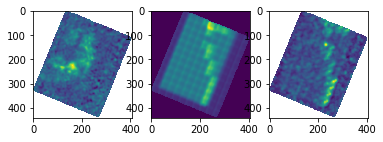

In [9]:
plt.subplot(131)
plt.imshow(i0[framei])
plt.subplot(132)
plt.imshow(w0[framei])
plt.subplot(133)
plt.imshow(rchi[framei])

In [10]:
print(np.nanmax(i0[framei]))
print(np.nanmax(rchi[framei]))
from astropy.io import fits
# fits.HDUList(fits.PrimaryHDU(data=i0)).writeto("/Users/dperera/testimg.fits", overwrite=True)
fits.HDUList(fits.PrimaryHDU(data=i0)).writeto("/Users/dperera/" + outfile, overwrite=True)

1422.66019402982
1.5768677004998104


In [9]:
resampler = Resample(grid_info['coordinates'].copy(), flxvals, error=errvals,
                     fix_order=fix_order, window=fit_wdw, order=order, robust=None,
                     negthresh=None, mode=edge_mode)
self = resampler
fit_threshold = 0
edge_algorithm = 'com_distance'
relative_smooth = True
error_weighting = False
get_error = True
jobs = 1
client = None
cval = np.nan
smoothing = 1/3, 1/3, 0.5  # fwhm or alpha
adaptive_smoothing = 1/3, 1/3, 0  # minimum window
settings = self.reduction_settings(
            smoothing, fit_threshold, cval, edge_threshold, edge_algorithm,
            relative_smooth, error_weighting, get_error,
            adaptive_smoothing, jobs, client)

grid = grid_info['grid']
args = grid
from astropy.stats import gaussian_fwhm_to_sigma
import bottleneck as bn
import numpy as np
from scipy.special import gamma
import warnings
from sofia_redux.toolkit.resampling.resample import scale_coordinates
from sofia_redux.toolkit.resampling.resample import ResampleGrid

def imshow(val): 
        plt.imshow(val[0].reshape(visitor_grid.shape)[35]) 

        
visitor_grid = ResampleGrid(
    *args, tree_shape=self.local_tree.tree_shape,
    build_tree=True, scale_factor=self._radius,
    scale_offset=self._scale_offsets, dtype=np.float64)

In [10]:
adaptive_smoothing = settings['adaptive_smoothing']
do_adaptive = adaptive_smoothing is not None
if do_adaptive:
    adaptive_smoothing = np.asarray(
        adaptive_smoothing, dtype=np.float64)
    if adaptive_smoothing.size == 0 or np.allclose(
            adaptive_smoothing, 0):
        do_adaptive = False

fwhm = np.atleast_1d(settings['alpha'])
alpha = 2 * (gaussian_fwhm_to_sigma * adaptive_smoothing * 0.5) ** 2

adapt = adaptive_smoothing != 0
alpha[~adapt] = fwhm[~adapt]
n_adapt = np.sum(adapt)

fwhm = np.atleast_1d(settings['alpha'])
if fwhm.size != self.features:
    fwhm = np.full(self.features, fwhm[0])


In [11]:
error = e0 * np.sqrt(n0)  # the error taken from variance over window
fit_error = np.sqrt(s0)
fit_sigma = fit_error / error

ro = np.sqrt(w0)
ro /= n0 ** (1 / self.features)
# convert alpha back to sigma for normalization
sigma = np.sqrt(alpha / 2)
ro /= np.prod(sigma) * (2 * np.pi) ** (self.features / 2)

ncoeffs = 


SyntaxError: invalid syntax (<ipython-input-11-62c9f11caa54>, line 11)

In [12]:
alpha

array([0.01001872, 0.01001872, 0.5       ])

In [ ]:
i0, e0, n0, w0, s0 = self.__call__(
    #scale_coordinates(self.local_tree.coordinates.copy(),
    #                  self._radius, self._scale_offsets, reverse=True),
    *grid,
    smoothing=alpha,
    relative_smooth=True,
    adaptive_smoothing=None, fit_threshold=settings['fit_threshold'],
    cval=settings['cval'], edge_threshold=settings['edge_threshold'],
    edge_algorithm=settings['edge_algorithm'],
    error_weighting=settings['error_weighting'],
    get_error=True, get_counts=True, get_weights=True, get_sigma=True,
    jobs=-2, client=None)

In [19]:
plt.imshow(s0[35])

NameError: name 's0' is not defined

Perform a serial reduction:

In [5]:
tstart_serial = time.time()
fluxs, stds, counts = resampler(*grid_info['grid'], **settings)
tstop_serial = time.time()
print("Completed in %s seconds" % (tstop_serial - tstart_serial))

Completed in 274.32647013664246 seconds


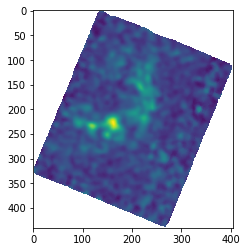

In [6]:
plt.imshow(fluxs[21])

Now attempt a parallel reduction using joblib:

In [7]:
# This is great for laptops or small sets of data
import psutil

# For smaller sets a large number of cores is fantastic,
# but half the number for this large set seems best.
# Using all cores on large data is slower than serial.
njobs = psutil.cpu_count() // 2
print("Using %i jobs" % njobs)

if njobs in [0, 1]:
    tstart_joblib = tstart_serial
    tstop_joblib = tstop_serial
    fluxj, stdj, countj = fluxs, stds, counts
    print("Would default to serial reduction... cancelling")
else:
    tstart_joblib = time.time()
    fluxj, stdj, countj = resampler(*grid_info['grid'], jobs=njobs, **settings)
    tstop_joblib = time.time()
print("Completed in %s seconds" % (tstop_joblib - tstart_joblib))

Using 4 jobs
Completed in 125.45053696632385 seconds


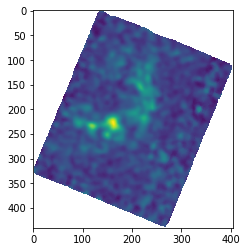

In [8]:
plt.imshow(fluxj[21])

Now attempt a parallel reduction using dask:

In [9]:
# dask seems to be great for large data on systems with a
# large amount of memory and cores.  Joblib is better otherwise.

# Indicate dask should be used by setting client to a dict or
# an existing dask.distributed.Client:

# client={}  # Setting memory_limit on my workstation fails
client = {'memory_limit': '12GB'}  # Not setting memory_limit on laptop fails

# NOTE: You may need to use client = {'memory_limit': '12GB'} or
# something to get it to work, this really depends on your system.
# See other worker and client keyword arguments in dask if you're
# having difficulty.

tstart_dask = time.time()
fluxd, stdd, countd = resampler(*grid_info['grid'], client=client, **settings)
tstop_dask = time.time()
print("Completed in %s seconds" % (tstop_dask - tstart_dask))

Completed in 182.93115210533142 seconds


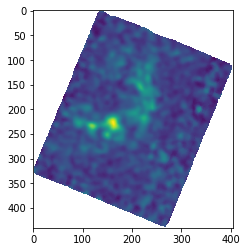

In [10]:
plt.imshow(fluxd[21])

In [11]:
tserial = tstop_serial - tstart_serial
tjoblib = tstop_joblib - tstart_joblib
tdask = tstop_dask - tstart_dask

print("Serial: %s seconds" % tserial)
print("Joblib: %s seconds" % tjoblib)
print("Dask: %s seconds" % tdask)
print('')

dask_factor = tserial / tdask
joblib_factor = tserial / tjoblib

print("Joblib is %s times faster than serial" % joblib_factor)
print("Dask is %s times faster than serial" % dask_factor)

assert np.allclose(fluxs, fluxj, equal_nan=True)
assert np.allclose(stds, stdj, equal_nan=True)
assert np.allclose(counts, countj, equal_nan=True)
assert np.allclose(fluxs, fluxd, equal_nan=True)
assert np.allclose(stds, stdd, equal_nan=True)
assert np.allclose(counts, countd, equal_nan=True)

# If we got here:
print('\nW' + 'O' * 5 + 'H' + 'O'* 10 + '!' * 20)

Serial: 274.32647013664246 seconds
Joblib: 125.45053696632385 seconds
Dask: 182.93115210533142 seconds

Joblib is 2.1867301389892266 times faster than serial
Dask is 1.4996159318927034 times faster than serial

WOOOOOHOOOOOOOOOO!!!!!!!!!!!!!!!!!!!!
